# Hybrid content based filter to reccomend classes to college students
## By: Khaled Hossain, Jahoon Koo, Carter Andrew, Jusung Kim
### 7/27/23
### References: 
1. https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4
2. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0284687
3. https://www.diva-portal.org/smash/get/diva2:1111865/FULLTEXT01.pdf
4. https://www.sciencedirect.com/science/article/pii/S1877050918302424
5. https://dl.acm.org/doi/10.1145/3460620.3460744
6. https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8
### Summary:
We have created three models to reccomend classes to students: Hybrid, user-user and item-item. To see all the details on developent of these models look at the [User-User development notebook](User-User-Content-Based.ipynb) and the [Item-Item development notebook](CSCI5502_Final_Project.ipynb)
These models were then integrated into a final hyrid system to provide a final reccomendation. For a deeper dive into the functioning of these models please reference either their respective notebooks or look at the provided [Project summary](Final-Report.pdf)

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

import sys

### Our datasets:
We pulled our data from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0284687. This is a compiled list of course enrollments from Peking University between 2014 to 2021. The data sets comprise 4568 students, 5591 courses, and a total of 208949 course enrollments


In [2]:
student_data = pd.read_excel("dataset/StudentInformationTable.xlsx")
course_data = pd.read_excel("dataset/CourseInformationTable.xlsx")
career_data = pd.read_excel("dataset/CourseSelectionTable.xlsx")

In [3]:
display(student_data.describe())
display(student_data.head(5))

,StudentId,EnrollmentYear
count,4568.000000,4568.000000
mean,2284.500000,2018.295972
std,1318.812344,1.191886
min,1.000000,2000.000000
25%,1142.750000,2018.000000
50%,2284.500000,2019.000000
75%,3426.250000,2019.000000
max,4568.000000,2020.000000


,StudentId,EnrollmentYear,Education,Major
0,1115,2018,Undergraduate,Biological Science
1,1108,2018,Undergraduate,Biological Science
2,1192,2018,Undergraduate,Urban and Rural Planning
3,1193,2018,Undergraduate,Urban and Rural Planning
4,1293,2018,Undergraduate,World History


In [4]:
display(course_data.describe())
display(course_data.head(5))

,CourseId,Grade
count,5591.000000,5225.000000
mean,2796.000000,2.436842
std,1614.127009,0.939362
min,1.000000,0.000000
25%,1398.500000,2.000000
50%,2796.000000,2.000000
75%,4193.500000,3.000000
max,5591.000000,12.000000


,CourseId,CourseName,College,Type,Grade,Prerequisite,Introduction
0,362,Fascinating Robot,College of Engineering,Whole school optional,2.0,NaN,This course is open to all students in the sch...
1,1045,Introduction to Seismology,School of Earth and Space Sciences,General elective course,2.0,NaN,This course is a quality education general cou...
2,1647,Speeches and oral cultures in China,Department of Chinese Language and Literature,Whole school optional,2.0,NaN,The course is based on the introduction and re...
3,1830,Modern Chinese History,Department of History,Required major,4.0,ancient Chinese history,This course is based on a large number of orig...
4,1834,Chinese Historiography,Department of History,optional,3.0,NaN,This course is a compulsory course for undergr...


In [5]:
display(career_data.describe())
display(career_data.head(5))

,StudentId,Semester,CourseId,Score
count,208949.000000,208941.000000,208949.000000,149223.000000
mean,1878.772590,1.505344,2578.111147,81.154792
std,1245.936537,0.532999,1732.925391,13.841620
min,1.000000,1.000000,1.000000,0.000000
25%,778.000000,1.000000,750.000000,78.000000
50%,1695.000000,1.000000,2569.000000,84.000000
75%,2914.000000,2.000000,4151.000000,90.000000
max,4568.000000,3.000000,5591.000000,100.000000


,StudentId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0
1,1115,18-19,1.0,148,Problem-solving on Higher Mathematics (B),School of Economics,NaN
2,1115,18-19,1.0,654,General Chemistry Practice,College of Engineering,NaN
3,1115,18-19,1.0,681,General Chemistry (B),Department of Medicine Teaching office,72.0
4,1115,18-19,1.0,684,General Chemistry Lab.（B）,Department of Medicine Teaching office,83.5


These datas can be merged to get all course enrollents mapped as rows. Key data on the rows is the course id, the student id, and the score the student recived in the class

In [6]:
career_data_clean = career_data.dropna()
career_student_data = pd.merge(career_data_clean, student_data, 'inner', 'StudentId')
display(career_student_data.head(5))

,StudentId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score,EnrollmentYear,Education,Major
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0,2018,Undergraduate,Biological Science
1,1115,18-19,1.0,681,General Chemistry (B),Department of Medicine Teaching office,72.0,2018,Undergraduate,Biological Science
2,1115,18-19,1.0,684,General Chemistry Lab.（B）,Department of Medicine Teaching office,83.5,2018,Undergraduate,Biological Science
3,1115,18-19,1.0,748,Physiology,College of Life Sciences,85.0,2018,Undergraduate,Biological Science
4,1115,18-19,1.0,844,Physiology Lab.,College of Life Sciences,75.0,2018,Undergraduate,Biological Science



# Data preprocessing:
There were a couple of critical preprocessing steps, 

Firstly we noticed some of the students were missing scores, we assume these are pass fail senarioes and not actually lossy data but because of the size of our dataset we felt comfortable just dropping these scores

For user-user we noticed there was a very steep dropoff of total courses taken by students around the 22-27 marks. We assumed this was a graduation thrshold in course count. This allowed us to drop all users with less courses than 22 and reccomend only on students who have taken many courses and succefully graduated. 

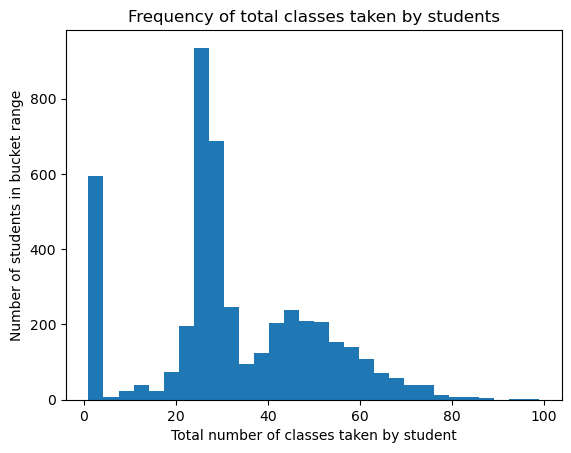

In [7]:
temp_matrix_def_not_jumping_ahead = career_student_data.pivot_table(index="StudentId", columns="CourseId", values="Score")
plt.hist(temp_matrix_def_not_jumping_ahead.count(axis=1), bins=30)
plt.title("Frequency of total classes taken by students")
plt.xlabel("Total number of classes taken by student")
plt.ylabel("Number of students in bucket range")
del(temp_matrix_def_not_jumping_ahead)

### Computing reccomendations:
We converted the essential functions and algrithms of our code into classes that can be imported and used elsewhere in the projects

We will demonstrate the functionality below. To learn more about their processes check the [class for user-user reccomendation](classes/user-user.py) and the [class for item-item reccomendation](classes/item-item.py)

In [8]:
from classes.user import userUserReccomender

In [9]:
user_reccomender = userUserReccomender(career_student_data)

#### Accuracy:
Here is how our algorithm works. Check the actual notebook for more information:
1. We take in a series of student ids, we simulate our testing data by dropping these students from our dataset of student-course data and appending an edited version of these students with only a subset of their courses
2. We then take this matrix full of our simulated training data and regular data and we iterate over our simulated training students and make a similarity array to all other users(not including our sim training data) by calulating cosine similarity on only the classes that particular student has taken.
3. We then rank the scores of similarity and choose a subset to use to calculate course scores
4. We find the course scores by computing the weighted average score in our similar users where the weight is the similarity of that user
5. We output three dataframes, one for the courses we used as input for reccomendation with the simulated training data, a dataframe of the courses we omitted from the training data(This is used to evaluate accuracy) and finally our predictions or reccomendations. We then use a threshold to detirmine a binary reccomend

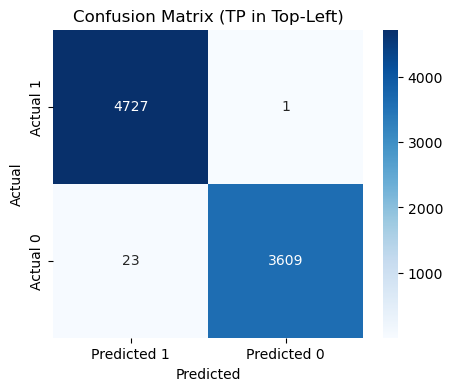

Accuracy: 0.9971291866028709
Precision: 0.9951578947368421
Recall: 0.9997884940778342
F1: 0.9974678202152353


In [10]:
oneone, onezero, zeroone, zerozero = 0,0,0,0
for propCourses in range(1,90):
    input_courses, output_courses, reccomendations = user_reccomender.calculateMultipleReccomendations(user_reccomender.training_data.StudentId.sample(5, replace=False).unique().tolist(), float(propCourses)/100, 1)
    for student in output_courses.index:
        output_courses.loc[student, ~output_courses.loc[student].isna()] = 1
        output_courses.loc[student, output_courses.loc[student].isna()] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) < 70] = 0
        reccomendations.loc[student, reccomendations.loc[student].fillna(0) > 70] = 1
        oneone += np.sum(np.logical_and(np.array(output_courses.loc[student]) == 1, 1 == np.array(reccomendations.loc[student])))
        onezero = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 1, 0 == np.array(reccomendations.loc[student])))
        zeroone = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 0, 1 == np.array(reccomendations.loc[student])))
        zerozero = np.sum(np.logical_and(np.array(output_courses.loc[student]) == 0, 0 == np.array(reccomendations.loc[student])))
cm = np.array([[oneone, onezero], [zeroone, zerozero]])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0']) # type: ignore
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TP in Top-Left)')
plt.show()
print("Accuracy:", (oneone + zerozero)/(oneone+ onezero + zeroone + zerozero))
print("Precision:", oneone/(oneone + zeroone))
print("Recall:", oneone/(oneone + onezero))
print("F1:", (2 * (oneone/(oneone + zeroone)) * (oneone/(oneone + onezero)))/((oneone/(oneone + zeroone))+ (oneone/(oneone + onezero))))

#### Showcase:

In [25]:
full_curriculum = user_reccomender.student_course_matrix.loc[4]
drop_courses = user_reccomender.student_course_matrix.loc[4].sample(10).index
sample_courses = full_curriculum.copy(deep=True)
sample_courses.loc[drop_courses] = np.nan
reccomendations = user_reccomender.calculateReccomendation(courses=sample_courses, student_id=4, num_similar_students=10)
print("Courses taken by student 4:")
print(course_data[course_data.CourseId.isin(sample_courses.dropna().index)].CourseName)
print("Courses reccomended")
print(course_data[course_data.CourseId.isin(reccomendations[reccomendations > 80].dropna().index)].CourseName)
print("Courses student had yet to take")
print(course_data[course_data.CourseId.isin(drop_courses)].CourseName)

Courses taken by student 4:
27                                            Taiji
36                  Western Music in the 20 century
60                              College English (3)
62                               Linear Algebra (B)
91                     Advanced Mathematics (B) (2)
                           ...                     
208                 Psychology, Conduct and Culture
209                               A taste of botany
210            Introduction of LiDAR Remote Sensing
211          Principles of Natural-Resource Science
212    Australian History and Culture Through Films
Name: CourseName, Length: 67, dtype: object
Courses reccomended
1                              Introduction to Seismology
6                    Introduction to Psychological Health
7                                                Football
8               History of Western Opera and Masterpieces
17                                 Outline of Chinese Art
                              ...             